In [5]:
import sys
sys.path.append('../')
from model.VQAE import VQAE
from model.MARL import MARL
from utils import device, add_noise
from tqdm import tqdm
import torch
from data.FloorPlanLoader import *
import torch.nn.functional as F
import random
import json
import torchvision
import matplotlib.pyplot as plt


USE_MULTISCALE = True
USE_MULTITASK = True

#Reproducability Checks:
random.seed(0) #Python
torch.manual_seed(0) #Torch
np.random.seed(0) #NumPy

#Hyperparameter
batch_size = 128
n_hiddens = 32
n_residual_hiddens = 32
n_residual_layers = 1
embedding_dim = 64
n_embeddings = 218
beta = .25
lr = 3e-3
epochs = 100
noise=False
noise_weight=0.05
img_channel=3 if USE_MULTISCALE else 1

In [6]:
def train_marl(train_loader=None, validation_loader=None, 
               data_variance=None, val_len=None, year_label_num=None, category_num=None,
               get_pretrain=True, use_multi_task=USE_MULTITASK):
    
    vqae = VQAE(n_hiddens, n_residual_hiddens, n_residual_layers,
                n_embeddings, embedding_dim, 
                beta, img_channel).to(device)
    if get_pretrain:
        vqae.load_state_dict(torch.load("./best_checkpoint/final/55-vqae-0.04753296934928414.pt"))

    marl = MARL(vqae, USE_MULTITASK, year_label_num, category_num)
    optimizer = torch.optim.Adam(marl.parameters(), lr=lr, amsgrad=False)
    train_recon_error = train_height_error = train_age_error = train_usage_error = []
    test_recon_error = test_height_error = test_age_error = test_usage_error = []


    best_loss = 2
    for epoch in range(0, epochs):
        with tqdm(train_loader, unit="batch") as tepoch:
            marl.train()
            for data_dict in tepoch:
                data = data_dict['image_tensor']
                bs = data.shape[0]
                data_no_noise = data.to(device)
                optimizer.zero_grad()

                if noise:
                    data = add_noise(data_no_noise, noise_weight=noise_weight)
                else:
                    data = data_no_noise
                pred = marl(data)

                # recon loss
                vq_loss, data_recon, perplexity = pred['vqae']
                recon_error = F.mse_loss(data_recon, data) / data_variance
                train_recon_error.append(recon_error.item())

                if USE_MULTITASK:
                    # height infer
                    height_pred = pred['height']
                    height_error = F.mse_loss(height_pred, data_dict['height'].to(device).view(bs,-1))
                    train_height_error.append(height_error.item())
                    # age infer
                    age_pred = pred['age']
                    labels = data_dict['age_label'].to(device).long()
                    age_error = F.cross_entropy(age_pred, labels)*0.3
                    train_age_error.append(age_error.item())
                    # category infer
                    category_pred = pred['category']
                    labels = data_dict['cate_onehot'].to(device)
                    criterion = torch.nn.BCEWithLogitsLoss()
                    category_error = criterion(category_pred, labels)*0.7
                    train_usage_error.append(category_error.item())

                loss = (recon_error + vq_loss) + height_error + age_error + category_error
                loss.backward()
                optimizer.step()
                tepoch.set_postfix(recon_error=float((recon_error+ vq_loss).detach().cpu()),
                                   height_error=float(height_error.detach().cpu()),
                                   age_error=float(age_error.detach().cpu()),
                                   category_error=float(category_error.detach().cpu()))
                
        avg_loss = 0
        marl.eval()
        with torch.no_grad():
            for data_dict in validation_loader:
                data = data_dict['image_tensor']
                bs = data.shape[0]
                data = data.to(device)

                pred = marl(data)
                # recon loss
                vq_loss, data_recon, perplexity = pred['vqae']
                recon_error = F.mse_loss(data_recon, data) / data_variance
                test_recon_error.append(recon_error.item())

                if USE_MULTITASK:
                    # height infer
                    height_pred = pred['height']
                    height_error = F.mse_loss(height_pred, data_dict['height'].to(device).view(bs,-1))
                    test_height_error.append(height_error.item())
                    # age infer
                    age_pred = pred['age']
                    labels = data_dict['age_label'].to(device).long()
                    age_error = F.cross_entropy(age_pred, labels)*0.3
                    test_age_error.append(age_error.item())
                    # category infer
                    category_pred = pred['category']
                    labels = data_dict['cate_onehot'].to(device)
                    criterion = torch.nn.BCEWithLogitsLoss()
                    category_error = criterion(category_pred, labels)*0.7
                    test_usage_error.append(category_error.item())

                loss = (recon_error.item() \
                        + height_error.item()\
                        + age_error.item()\
                        + category_error.item()\
                        ) * batch_size
                avg_loss += loss / val_len
                
                
        if epoch%5==0 and avg_loss<best_loss:
            best_loss = avg_loss
            best_epoch = epoch
            torch.save(marl.state_dict(), f"./checkpoint/{best_epoch}-vqae-{best_loss}.pt")
            torch.save(optimizer.state_dict(), f"./checkpoint/{best_epoch}-adam-{best_loss}.pt")
            if USE_MULTITASK:
                error = {
                    'train_recon_error': train_recon_error,
                    'train_height_error': train_height_error,
                    'train_age_error': train_age_error,
                    'train_usage_error': train_usage_error,
                    'test_recon_error': test_recon_error,
                    'test_height_error': test_height_error,
                    'test_age_error': test_age_error,
                    'test_usage_error': test_usage_error
                }
            else:
                error = {
                    'train_recon_error': train_recon_error,
                    'test_recon_error': test_recon_error
                }
            with open(f"./checkpoint/{best_epoch}-error-{best_loss}.json", 'w', encoding ='utf8') as json_file:
                json.dump(error, json_file, ensure_ascii = False)

        print(f'Validation Loss: {avg_loss}')


In [13]:
#Load Dataset
floor = FloorPlanDataset(multi_scale=True, root='../data/data_root/data00/', data_config='../data/data_config/', preprocess=True)
data_variance = floor.var
val_len = int(len(floor)/10)
train_set, val_set = torch.utils.data.random_split(floor, [len(floor)-val_len, val_len])

print(f"data shape: {floor[0]['image_tensor'].shape}, dataset size: {len(floor)}, data variance: {data_variance}")
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
validation_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = False)

data shape: torch.Size([1, 56, 56]), dataset size: 1774, data variance: 0.002072493312880397


In [18]:
vqae = VQAE(n_hiddens, n_residual_hiddens, n_residual_layers,
            n_embeddings, embedding_dim, 
            beta, img_channel).to(device)
marl = MARL(vqae, True, floor.age_label_num, floor.category_num)
marl.load_state_dict(torch.load("../best_checkpoint/10-marl-0.7733164590012002.pt",map_location=torch.device('cpu')))

<All keys matched successfully>

In [37]:
import json
with open("../checkpoint/98-error-2.3394897454707637.json") as json_file:
    error = json.load(json_file)

In [38]:
error['train_recon_error']

[2.011993408203125,
 11.670970916748047,
 1.0134755373001099,
 4.078924655914307,
 7.696089744567871,
 7.132714748382568,
 3.844581127166748,
 1.029181957244873,
 1.112105131149292,
 2.901097059249878,
 3.174293041229248,
 2.421905755996704,
 1.231189250946045,
 1.62992525100708,
 1.1727079153060913,
 0.696225643157959,
 0.82609623670578,
 1.0682123899459839,
 0.6301771998405457,
 0.5499994158744812,
 0.5286310315132141,
 0.5753424167633057,
 0.5742708444595337,
 0.5026629567146301,
 0.42199385166168213,
 0.46953269839286804,
 0.45710089802742004,
 0.4581559896469116,
 0.3959811329841614,
 0.32556474208831787,
 0.3292905390262604,
 0.337890088558197,
 0.3118840754032135,
 0.30836719274520874,
 0.2833920121192932,
 0.27534452080726624,
 0.2785041928291321,
 0.2787695527076721,
 0.2328743189573288,
 0.22963197529315948,
 0.23353326320648193,
 0.24176344275474548,
 0.23152853548526764,
 0.23577508330345154,
 0.24777236580848694,
 0.214558407664299,
 0.2166396975517273,
 0.1864627450704574

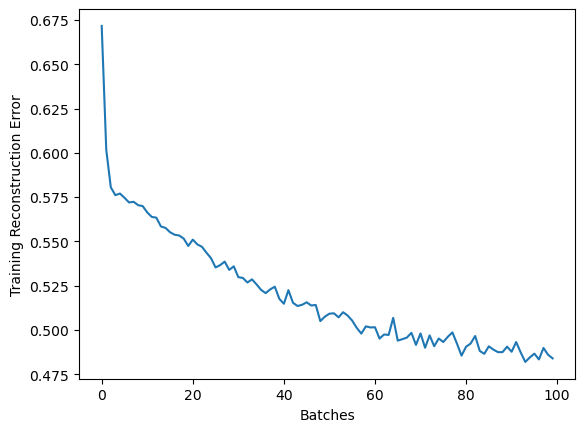

In [39]:
plt.plot(error['train_usage_error'][:100])
plt.xlabel('Batches')
plt.ylabel('Training Reconstruction Error')
plt.show()


In [42]:
vqae.eval()
temp_loader = torch.utils.data.DataLoader(val_set,batch_size=8,shuffle=True)
(valid_originals) = next(iter(temp_loader))
valid_originals = valid_originals['image_tensor'].to(device)
if valid_originals.shape[1] == 1:  # Check if it has 1 channel
    valid_originals = valid_originals.repeat(1, 3, 1, 1)  # Convert to 3-channel

_, valid_recon, _ = vqae(valid_originals)

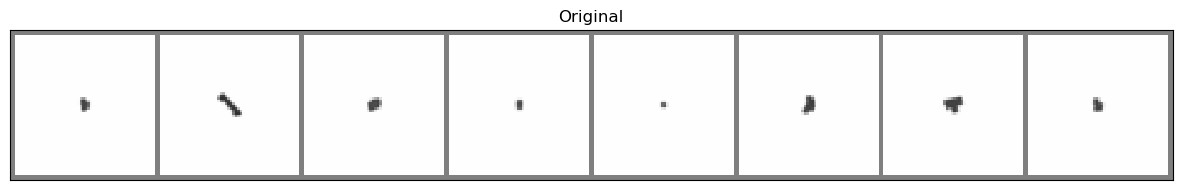

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


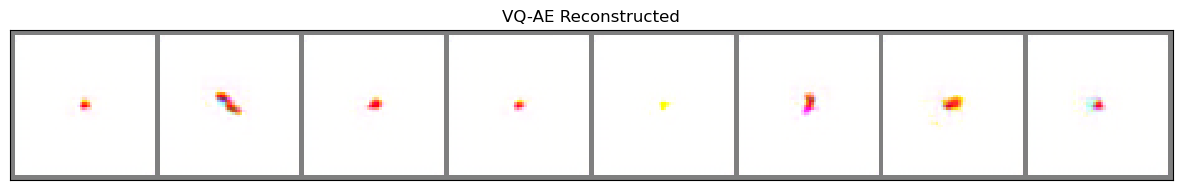

In [50]:
def show(img, title):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.set_title(title)

plt.figure(figsize=(15,10))
show(torchvision.utils.make_grid(valid_originals.cpu()) + 0.5, "Original")
plt.show()
plt.figure(figsize=(15,10))
show(torchvision.utils.make_grid(valid_recon.cpu().data) + 0.5, "VQ-AE Reconstructed")
plt.show()

def rescale_img(multi_scaled_channels): #B,C,H,W
    composed_1 = transforms.Resize(700)
    composed_2 = transforms.Compose([
                                    transforms.Resize(224),
                                    transforms.Pad(238, fill=1.0)])
    composed_3 = transforms.Pad(294, fill=1.0)
    composed_0 = transforms.Compose([transforms.Grayscale(),
                        transforms.CenterCrop(224)])
    
    channel_1 = composed_1(multi_scaled_channels[:,0:1,:,:])
    channel_2 = composed_2(multi_scaled_channels[:,1:2,:,:])
    channel_3 = composed_3(multi_scaled_channels[:,2:3,:,:])
    print(f"channel_1 shape: {channel_1.shape}")
    print(f"channel_2 shape: {channel_2.shape}")
    print(f"channel_3 shape: {channel_3.shape}")
    # Resize channel_3 to match channel_1 and channel_2
    target_size = channel_1.shape[-2:]  # Get (height, width) from channel_1
    channel_3 = F.interpolate(channel_3, size=target_size, mode="bilinear", align_corners=False)

    return composed_0(torch.cat([channel_1,channel_2,channel_3], dim=1))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


channel_1 shape: torch.Size([8, 1, 700, 700])
channel_2 shape: torch.Size([8, 1, 700, 700])
channel_3 shape: torch.Size([8, 1, 644, 644])
channel_1 shape: torch.Size([8, 1, 700, 700])
channel_2 shape: torch.Size([8, 1, 700, 700])
channel_3 shape: torch.Size([8, 1, 644, 644])


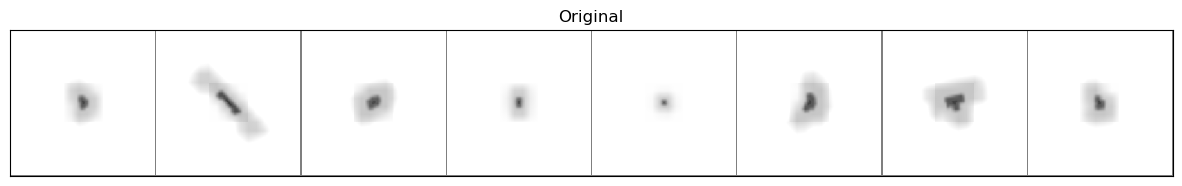

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


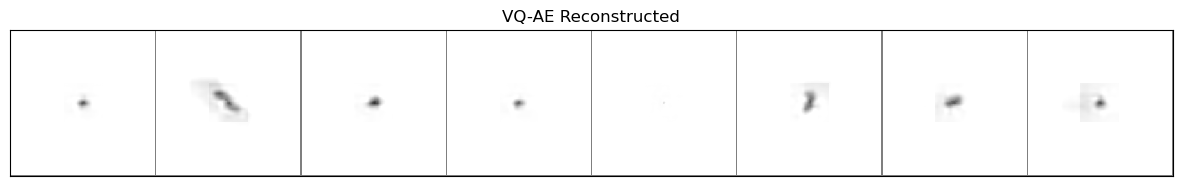

In [51]:


valid_originals = rescale_img(valid_originals)
valid_recon = rescale_img(valid_recon)

plt.figure(figsize=(15,10))
show(torchvision.utils.make_grid(valid_originals.cpu())+0.5, "Original")
plt.show()
plt.figure(figsize=(15,10))
show(torchvision.utils.make_grid(valid_recon.cpu().data) + 0.5, "VQ-AE Reconstructed")
plt.show()


In [60]:
marl.eval()
temp_loader = torch.utils.data.DataLoader(val_set,batch_size=16,shuffle=True)
(valid_originals) = next(iter(temp_loader))
valid_originals = valid_originals['image_tensor'].to(device)

# Convert grayscale (1-channel) to RGB (3-channel)
if valid_originals.shape[1] == 1:
    valid_originals = valid_originals.repeat(1, 3, 1, 1)  # Repeat across channel dimension



In [61]:
valid_recon = marl(valid_originals)
valid_recon

RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x9 and 64x1)